In [1]:
import difflib
import math
import random
import string

random.seed(123)

import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import Sclite_helper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.CTCDecoder.BeamSearch import ctcBeamSearch

from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [2]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
random.seed(42)

In [5]:
figs_to_plot = 4
images = []

n = 0
for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

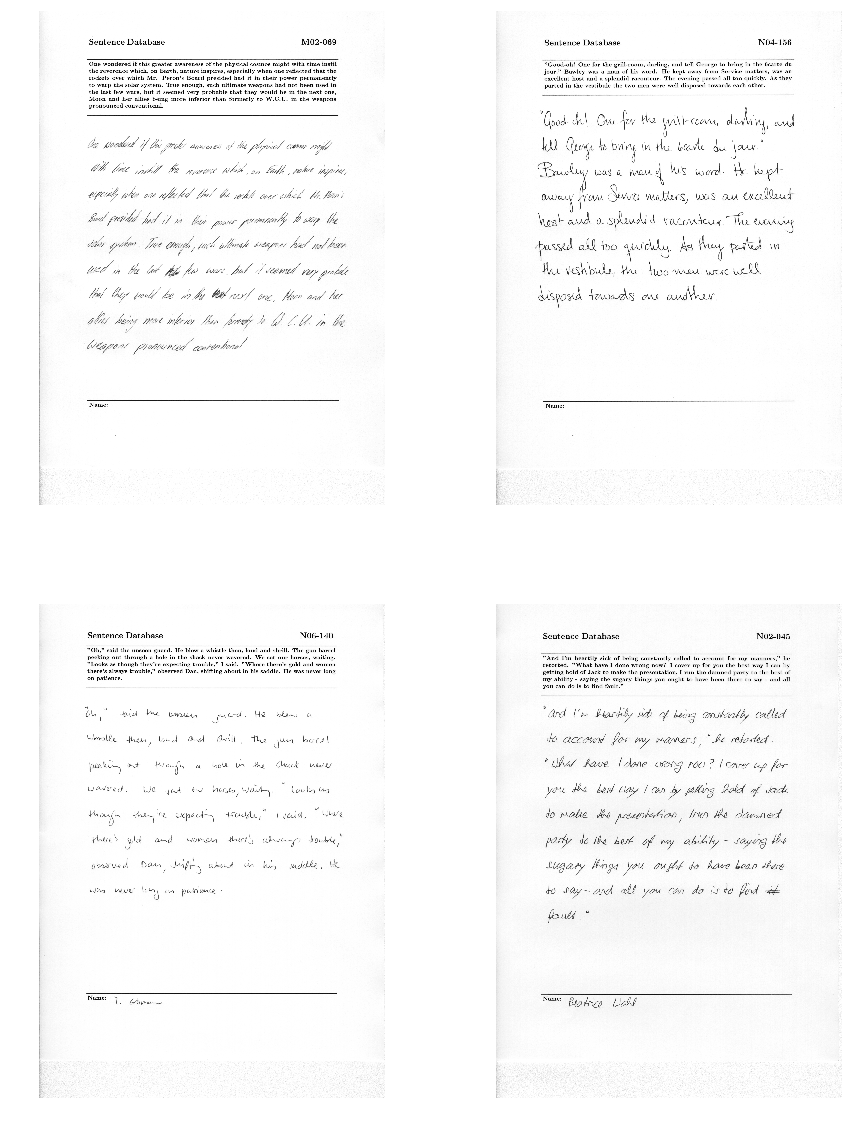

In [6]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

### Paragraph segmentation

Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [7]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [8]:
paragraph_segmentation_net.hybridize()

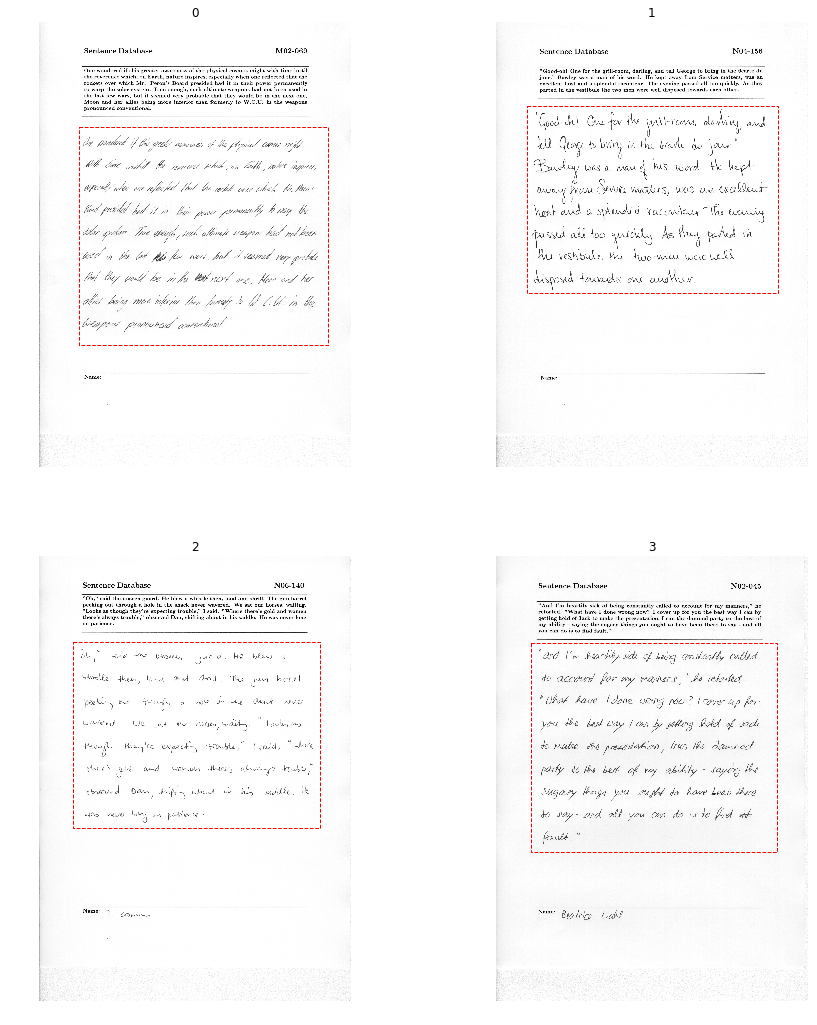

In [9]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



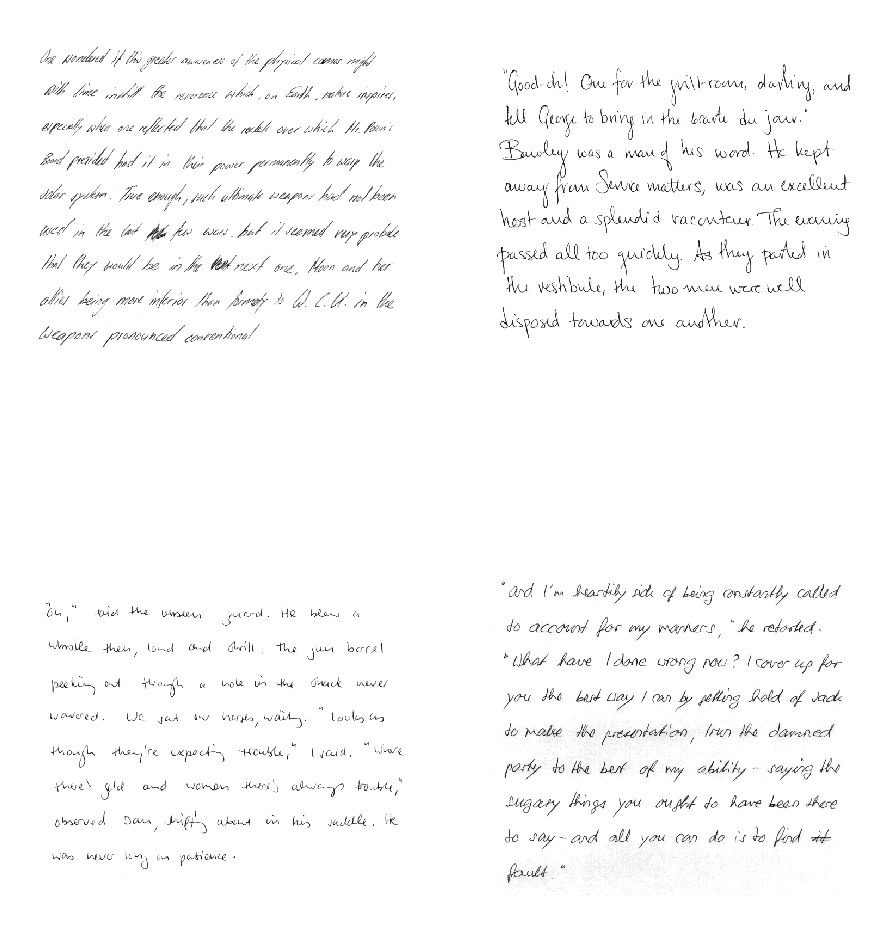

In [10]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation

Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [11]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

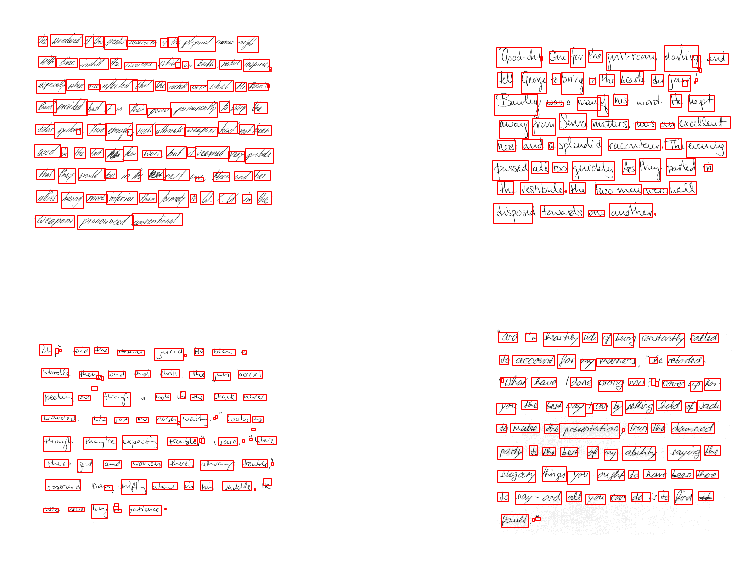

In [12]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

### Word to line image processing
Algorithm to sort then group all words within a line together.

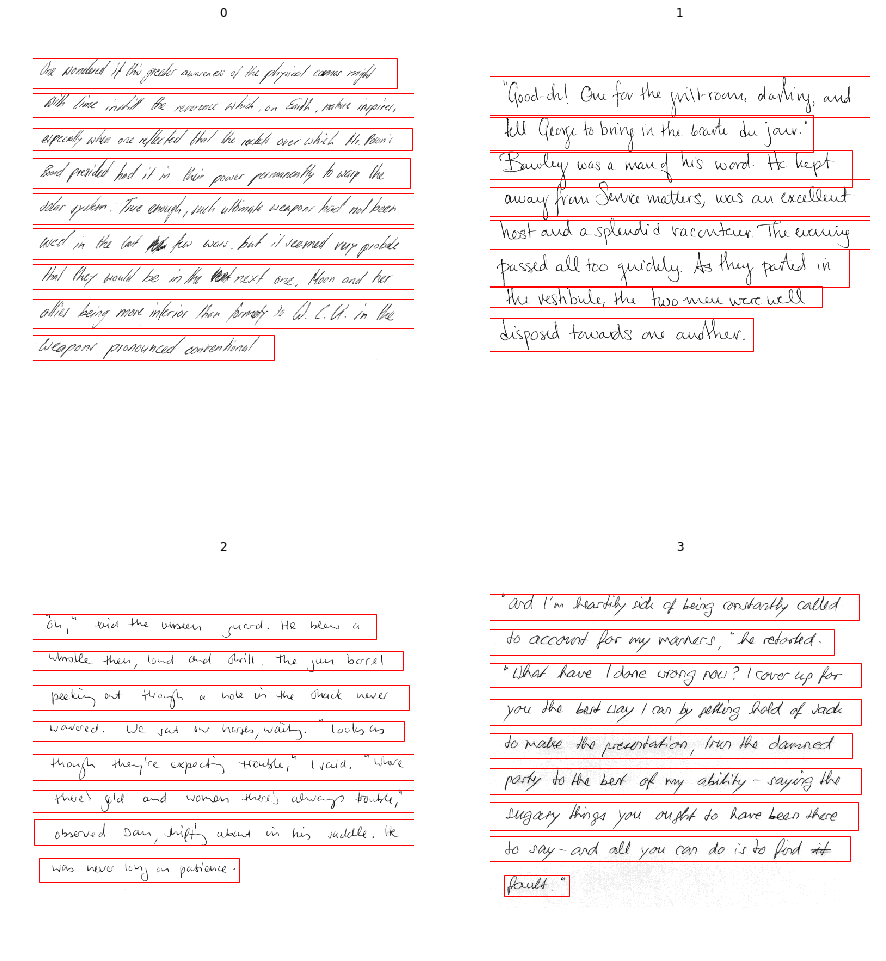

In [13]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

## Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [14]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("model_checkpoint/handwriting.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [15]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [16]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [17]:
def get_beam_search(prob, width=20, k=4):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [18]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('model_checkpoint/denoiser_highhead_2.params', ctx=ctx)

In [19]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [20]:
ctx_nlp = mx.gpu(3)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

We use beam search to sample the output of the denoiser

In [21]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=30,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [22]:
def generate_sequences(sampler, inputs, begin_states, sentence, language_model):
    samples, scores, valid_lengths = sampler(inputs, begin_states)
    samples = samples[0].asnumpy()
    scores = scores[0].asnumpy()
    valid_lengths = valid_lengths[0].asnumpy()
    max_score = -10e20
    
    # We penalize sentences that have out of vocabulary words 
    # that do not start with a capital letter
    for i, sample in enumerate(samples):
        tokens = decode_char(sample[:valid_lengths[i]])
        tokens = [i.replace("&quot", '\"').replace("&amp", "&").replace('";', '\"') for i in moses_tokenizer(tokens)]
        score = 0
        for t in tokens:
            if t in vocab or (len(t) > 0 and t[0].isupper()):
                score += 0
            else:
                score -= 1
            score -= 0
        if score == max_score:
            max_score = score
            best_tokens.append(tokens)
        elif score > max_score:
            max_score = score
            best_tokens = [tokens]

    

    # Smallest edit distance
    # We then take the sentence with the lowest edit distance
    # From the predicted original sentence
    best_dist = 1000
    output_tokens = best_tokens[0]
    best_tokens_ = []
    for tokens in best_tokens:
        dist = leven.levenshtein(sentence, ' '.join(moses_detokenizer(tokens)))
        if dist < best_dist:
            best_dist = dist
    for tokens in best_tokens:
        dist = leven.levenshtein(sentence, ' '.join(moses_detokenizer(tokens)))
        if dist <= best_dist + 1:
            best_tokens_.append(tokens)
            
    
    # Lowest ppl
    # If we still have ties we take the sentence with the lowest
    # Perplexity score according to the language model
    best_ppl = 10e20
    for tokens in best_tokens_:
        if len(tokens) > 1:
            inputs = vocab[tokens]
            hidden = language_model.begin_state(batch_size=1, func=mx.nd.zeros, ctx=ctx_nlp)
            output, _ = language_model(mx.nd.array(inputs).expand_dims(axis=1).as_in_context(ctx_nlp), hidden)
            output = output.softmax()
            l = 0
            for i in range(1, len(inputs)):
                l += -output[i-1][0][inputs[i]].log()
            ppl = (l/len(inputs)).exp()
            if ppl < best_ppl:
                output_tokens = tokens
                best_ppl = ppl

    return ' '.join(moses_detokenizer(output_tokens))

In [23]:
def get_denoised(prob):
    text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generate_sequences(beam_sampler, inputs, states, text, language_model)
    print(output)
    return output.strip()

In [24]:
sentence = "party to the bert of may ability - saying the"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
generate_sequences(beam_sampler, inputs, states, sentence, language_model)

'party to the best of my ability - saying the'

## Qualitative Result

### No language model

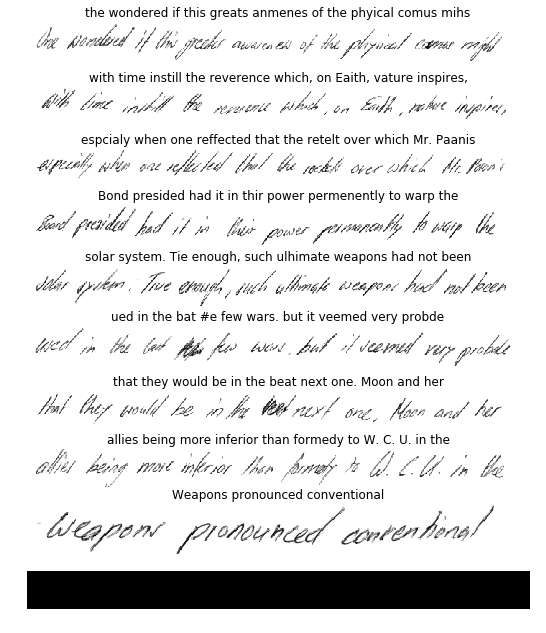

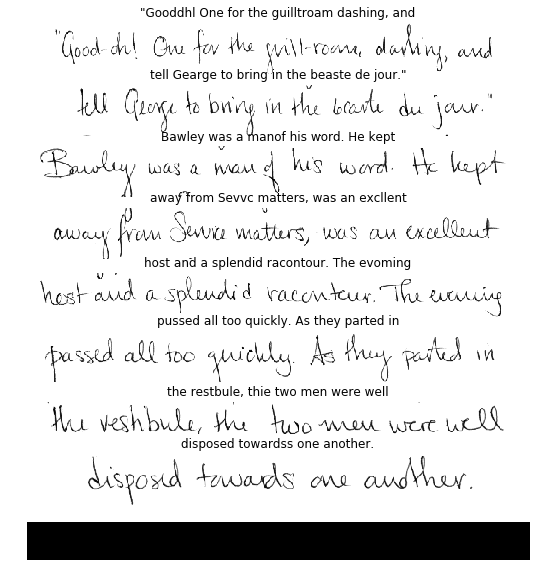

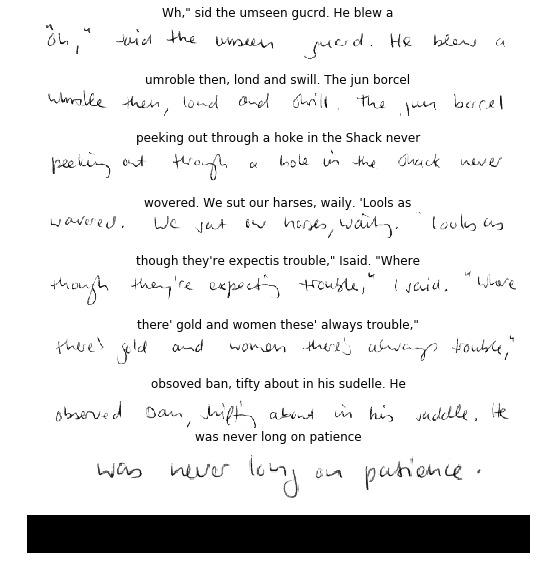

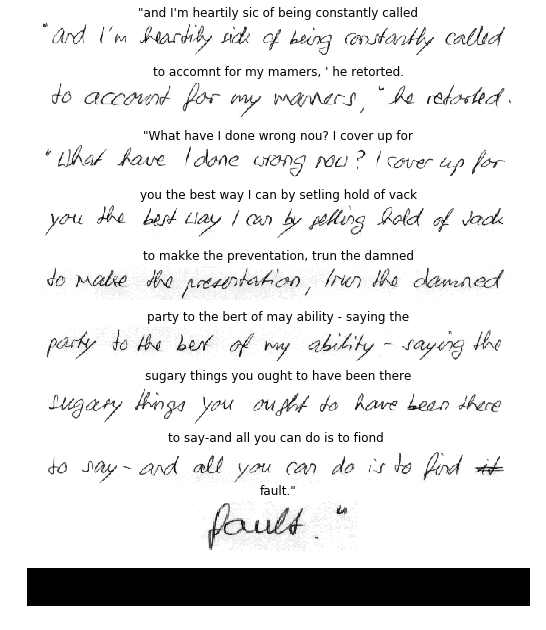

In [25]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(9, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Using CTC Beam Search on the recognition probabilities

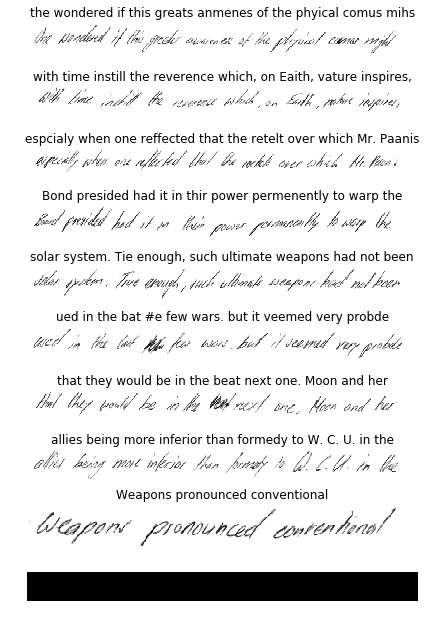

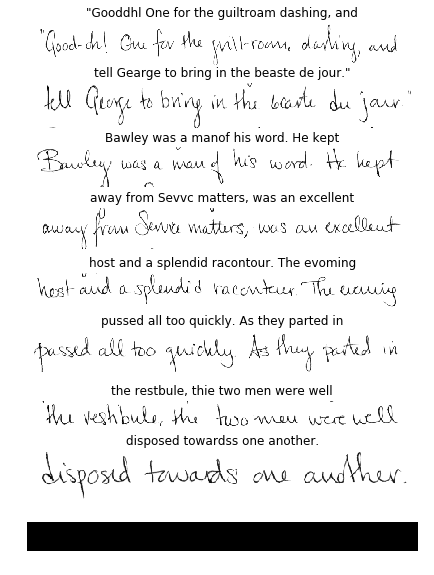

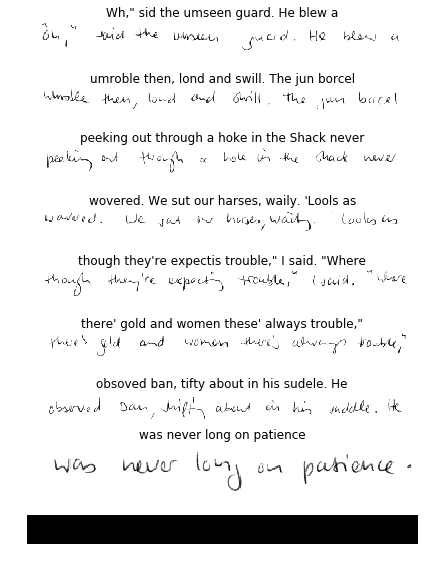

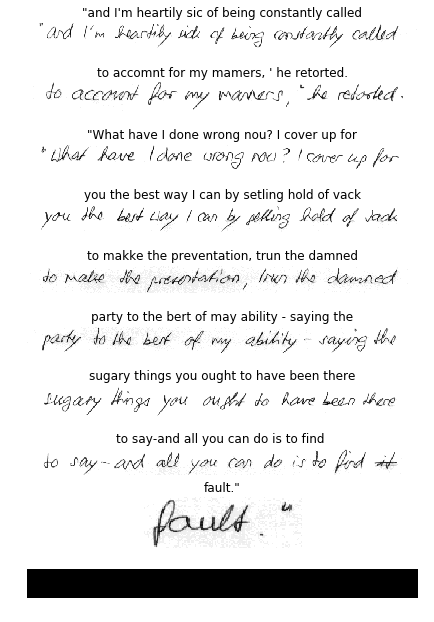

In [26]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_beam_search(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

### Using Denoiser

the wondered if this greatest manner of the physical comes with
with time in still the reverence which, on faith, nature inspires,
especially when one reflected that the result over which Mr. Prancis
Bond presided had it in their power permanently to warp the
solar system. Time enough, such climate weapons had not been
used in the bat a few words. But it seemed very proble
that they would be in the best next one. Moon and her
allies being more inferior than formerly to W. C.C.U. in the
Weapons pronounced conventional.
"Good is one for the guilt room dashing, and
tell George to bring in the beasts de jour. "
Bawley was a man of his word. He kept
away from Sevre matters, was an excellent
host and a splendid contour. The evening
pushed all too quickly. As they parted in
the vestibule, the two men were well
disposed towards one another.
Who, "said the unseen guard. He blew a
improbable then, land and still. The gun barrel
peeking out through a hole in the shock never
covered. We shut our h

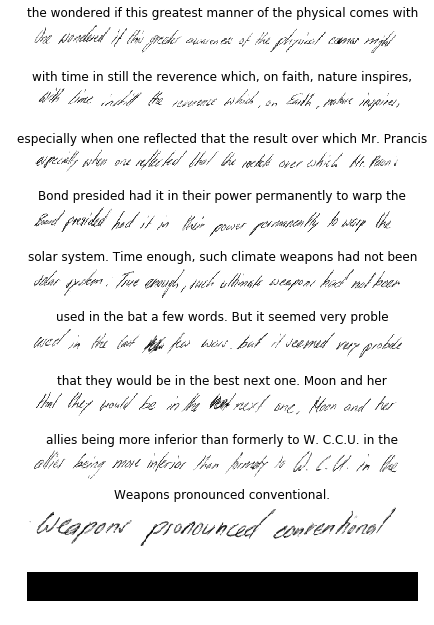

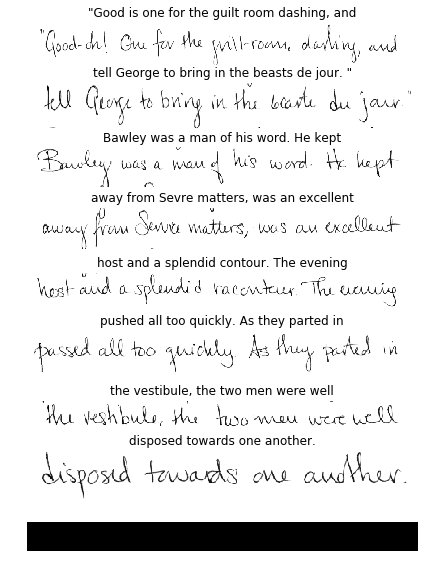

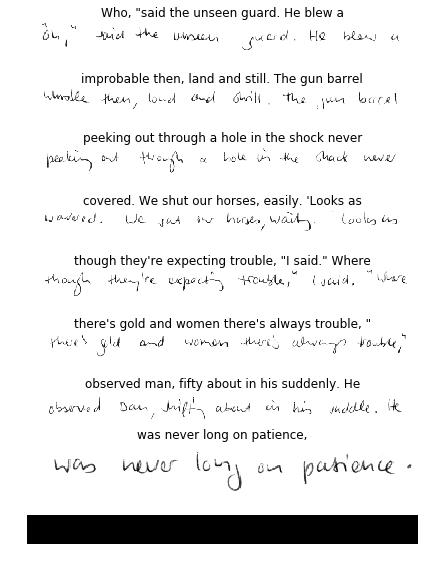

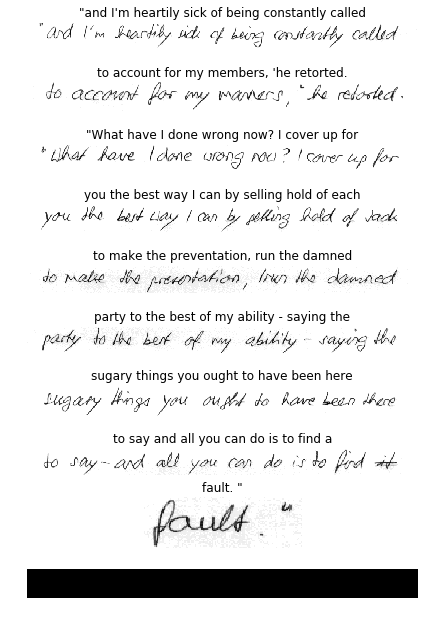

In [27]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_denoised(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [28]:
sclite = Sclite_helper()

def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')[:-1]
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))
    return er

In [ ]:
get_qualitative_results(get_arg_max)

 50%|████▉     | 115/232 [00:55<00:56,  2.06it/s]

In [ ]:
get_qualitative_results(get_beam_search)

In [ ]:
cer_denoiser = get_qualitative_results(get_denoised)
cer_denoiser

#### ideas:
    - weighted levenshtein
    - re-trained the language model on GBW [~ didn't work too well]
    - only penalize non-existing words
    - Add single word training for denoiser
    - having 2 best edit distance rather than single one
    - split sentences based on punctuation